In [148]:
import os, shutil, glob
import time, requests
import datetime as datetime
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
os.makedirs(os.path.join("Cellphones Data","Dataset"),exist_ok = True)

In [63]:
def Scrape_Product(URLs, Name):
    driver = webdriver.Edge()

    try:
        URL = URLs
        driver.get(URL)
        
        def close_popups():
            while True:
                try:
                    close_button = WebDriverWait(driver, 2).until(
                        EC.element_to_be_clickable((By.CSS_SELECTOR, "button.modal-close.is-large"))
                    )
                    close_button.click()
                    time.sleep(0.5)
                except Exception:
                    break

            while True:
                try:
                    close_promo_button = WebDriverWait(driver, 2).until(
                        EC.element_to_be_clickable((By.CSS_SELECTOR, "button.cancel-button-top"))
                    )
                    close_promo_button.click()
                    time.sleep(0.5)
                except Exception:
                    break
        
        while True:
            try:
                close_popups()            
                show_more_button = WebDriverWait(driver, 2).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, "a.button.btn-show-more.button__show-more-product"))
                )
                show_more_button.click()
                time.sleep(2)
            except Exception as e:
                break

        Page = driver.page_source
        Soup = BeautifulSoup(Page, "lxml")
        
        Product_Names = Soup.find_all("div", class_="product__name")
        Product_Prices = Soup.find_all("p", class_="product__price--show")

        Product_Information = {}

        if len(Product_Names) == len(Product_Prices):
            for name, price in zip(Product_Names, Product_Prices):
                product_name = name.get_text(strip=True)
                product_price = price.get_text(strip=True).replace("₫", "").replace(".", "").strip()
                Product_Information[product_name] = product_price
        else:
            print("Số lượng tên sản phẩm và giá sản phẩm không khớp!")

        for product, price in Product_Information.items():
            print(f"Tên sản phẩm: {product} - Giá: {price}")

    finally:
        driver.quit()
    
    df = pd.DataFrame(list(Product_Information.items()), columns=["Tên sản phẩm", "Giá"])
    df.to_csv(f"{Name}.csv", header=True, index=False)

In [64]:
def Scrape_Product_URL():
    URL = "https://cellphones.com.vn/"
    Homepage = requests.get(URL).text
    Source_Code = BeautifulSoup(Homepage, "lxml")
    
    Links = Source_Code.find_all("div", class_=["multiple-link", "label-menu-tree"])

    Product_Links = {}
    for Link_Section in Links:
        a_Tags = Link_Section.find_all("a")
        for a in a_Tags:
            Product_Type = a.get_text(strip=True).replace(",", "")
            href = a.get("href")
            if href and href.endswith('.html'):
                Product_Links[Product_Type] = href

    del Product_Links['Hàng cũ']

    return Product_Links

In [65]:
def Scrape_Per_URL():
    Links = Scrape_Product_URL()
    for Num in Links:
        Scrape_Product(Links[Num], Num)
        shutil.move(f"{Num}.csv", os.path.join("Cellphones Data","Dataset"))
Scrape_Per_URL()   

Tên sản phẩm: Samsung Galaxy S24 Plus 12GB 512GB - Giá: 27490000đ
Tên sản phẩm: TECNO SPARK Go 2024 4GB 64GB - Giá: 2050000đ
Tên sản phẩm: TECNO SPARK 20PRO+ - Giá: 5000000đ
Tên sản phẩm: TECNO SPARK Go 1 4GB 64GB - Giá: 2290000đ
Tên sản phẩm: Samsung Galaxy S24 Plus 12GB 256GB - Giá: 23990000đ
Tên sản phẩm: Viettel T2 4G - Giá: 550000đ
Tên sản phẩm: TECNO POVA 5 8GB 128GB - Giá: 4100000đ
Tên sản phẩm: Tecno Pova 6 (8GB/256GB) - Giá: 5890000đ
Tên sản phẩm: realme C61 (6GB 128GB) - Giá: 3990000đ
Tên sản phẩm: Masstel izi 16 4G - Giá: 410000đ
Tên sản phẩm: TECNO SPARK 20 8GB 128GB - Giá: 3190000đ
Tên sản phẩm: Masstel izi T2 4G - Giá: 460000đ
Tên sản phẩm: Samsung Galaxy M55 (12GB 256GB) - Giá: 10990000đ
Tên sản phẩm: realme C61 (4GB 128GB) - Giá: 3590000đ
Tên sản phẩm: OPPO Find X5 Pro 12GB 256GB - Giá mới chỉ có tại CellphoneS - Giá: 15990000đ
Tên sản phẩm: OPPO Reno10 Pro+ 5G 12GB 256GB - Giá: 14190000đ
Tên sản phẩm: Samsung Galaxy S23 Ultra 12GB 512GB - Giá: 27990000đ
Tên sản phẩm: S

In [66]:
def Data_Cleaning():
    for File_Path in glob.glob(os.path.join("Cellphones Data", "Dataset", "*.csv")):
        File = pd.read_csv(File_Path)

        File["Giá"] = File["Giá"].astype(str).str.replace("đ", "").str.strip()

        File["Trạng thái"] = File["Giá"].apply(
            lambda x: "Còn hàng" if x.isdigit() else "Hết hàng"
        )

        File["Ngày"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        File["Ngày"] = pd.to_datetime(File["Ngày"])

        File.to_csv(File_Path, index=False, encoding="utf-8-sig")

Data_Cleaning()

In [84]:
def Product_Classification():
    Product_Classifications = ["Điện thoại.csv", "Tablet.csv", "Laptop.csv", "Đồng hồ.csv"]
    for type in Product_Classifications:
        File = pd.read_csv(os.path.join("Cellphones Data", "Dataset", type))
        
        if type == "Điện thoại.csv":
            File["Giá"] = pd.to_numeric(File["Giá"], errors="coerce")
            File["Phân khúc"] = pd.cut(File["Giá"],bins=[0, 6000000, 10000000, 18000000, float("inf")],labels=["Giá rẻ", "Tầm trung", "Cận cao cấp", "Flagship"]).astype(str)
        elif type == "Tablet.csv":
            File["Giá"] = pd.to_numeric(File["Giá"], errors="coerce")
            File["Phân khúc"] = pd.cut(File["Giá"],bins=[0, 6000000, 12000000, 20000000, float("inf")],labels=["Giá rẻ", "Tầm trung", "Cận cao cấp", "Flagship"]).astype(str)
        elif type == "Laptop.csv":
            File["Giá"] = pd.to_numeric(File["Giá"], errors="coerce")
            File["Phân khúc"] = pd.cut(File["Giá"],bins=[0, 20000000, 25000000, 30000000, 40000000,float("inf")],labels=["Dưới 20 triệu", "Từ 20 đến 25 triệu", "Từ 25 đến 30 triệu", "Trên 30 đến 40 triệu", "Trên 40 triệu"]).astype(str)  
        else:
            File["Giá"] = pd.to_numeric(File["Giá"], errors="coerce")
            File["Phân khúc"] = pd.cut(File["Giá"],bins=[0, 2000000, 5000000, 10000000, float("inf")],labels=["Giá rẻ", "Tầm trung", "Cận cao cấp", "Flagship"]).astype(str)
                
        File.to_csv(os.path.join("Cellphones Data", "Dataset", type), index=False, encoding="utf-8-sig")    

Product_Classification()

In [149]:
pd.options.display.float_format = '{:.3f}'.format
Mobile = pd.read_csv(os.path.join("Cellphones Data", "Dataset", "Điện thoại.csv"))
Segment_Mobile_Avg = Mobile.groupby('Phân khúc')['Giá'].mean().reset_index()
Segment_Mobile_Avg.columns = ['Phân khúc', 'Giá trung bình theo phân khúc']
Segment_Mobile_Avg


,Phân khúc,Giá trung bình theo phân khúc
0,Cận cao cấp,14167608.696
1,Flagship,29576790.123
2,Giá rẻ,3286369.863
3,Tầm trung,8277368.421


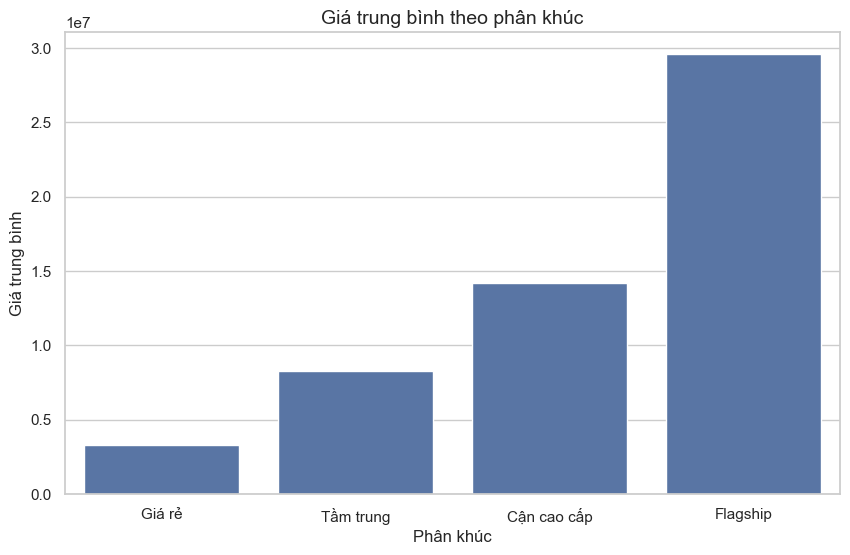

In [150]:
Segment_Mobile_Avg = Segment_Mobile_Avg.sort_values(by='Giá trung bình theo phân khúc', ascending=True)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='Phân khúc', y='Giá trung bình theo phân khúc', data=Segment_Mobile_Avg)

plt.title('Giá trung bình theo phân khúc', fontsize=14)
plt.xlabel('Phân khúc', fontsize=12)
plt.ylabel('Giá trung bình', fontsize=12)

plt.show()